In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as pyplot

# Device conf
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print("Running on CPU")

print(f"PyTorch version: {torch.__version__}, Device: {device}")

PyTorch version: 2.3.1, Device: mps


Downloading...
Data Loaded Successfully: torch.Size([64, 1, 32, 32]), torch.Size([64])


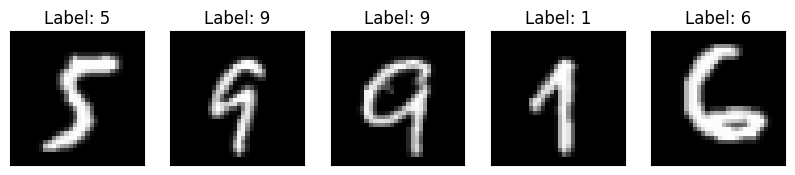

In [2]:
def get_data_loader(batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Downloading dataset
    print("Downloading...")
    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

    # Building data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader


# Testing the data loader
if __name__ == "__main__":
    train_loader, test_loader = get_data_loader()
    data_iter = iter(train_loader)
    images, labels = next(data_iter)

    print(f"Data Loaded Successfully: {images.shape}, {labels.shape}")

    figure = pyplot.figure(figsize=(10, 4))
    for i in range(5):
        ax = figure.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
        img = images[i].numpy().transpose((1, 2, 0))
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"Label: {labels[i].item()}")
    pyplot.show()

In [3]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.s2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.s4 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.c5 = nn.Linear(16 * 5 * 5, 120)
        self.f6 = nn.Linear(120, 84)
        self.output = nn.Linear(84, 10)
        self.act = nn.Tanh()

    def forward(self, x):
        x = self.act(self.c1(x))
        x = self.s2(x)
        x = self.act(self.c3(x))
        x = self.s4(x)
        x = x.view(x.size(0), -1)
        x = self.act(self.c5(x))
        x = self.act(self.f6(x))
        x = self.output(x)

        return x


if __name__ == "__main__":
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    model = LeNet5().to(device)
    print("✅ Model Architecture Created:")
    print(model)

    dummy_input = torch.randn(1, 1, 32, 32).to(device)

    output = model(dummy_input)

    print(f"\n✅ Output Shape: {output.shape}")

    if output.shape == torch.Size([1, 10]):
        print("🎉 Success! Dimensions are correct. Ready for training.")
    else:
        print("❌ Error: Dimensions do not match [1, 10]. Check calculations.")

✅ Model Architecture Created:
LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (c5): Linear(in_features=400, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
  (act): Tanh()
)

✅ Output Shape: torch.Size([1, 10])
🎉 Success! Dimensions are correct. Ready for training.


In [4]:
learning_rate = 0.01
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

def train_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            loss_val = loss.item()
            current = batch * len(X)
            print(f"📉 Loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

if __name__ == "__main__":
    print("🚀 Starting training for 1 Epoch to test the loop...")
    train_one_epoch(train_loader, model, criterion, optimizer)
    print(" End of Day 4 test.")

🚀 Starting training for 1 Epoch to test the loop...
📉 Loss: 2.299403  [    0/60000]
📉 Loss: 0.216378  [25600/60000]
📉 Loss: 0.105987  [51200/60000]
 End of Day 4 test.


In [5]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)

            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

if __name__ == "__main__":

    epochs = 5
    print(f"🚀 Starting training for {epochs} epochs...\n")

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_one_epoch(train_loader, model, criterion, optimizer)
        test_loop(test_loader, model, criterion)

    print("Done! 🎉")

🚀 Starting training for 5 epochs...

Epoch 1
-------------------------------
📉 Loss: 0.356909  [    0/60000]
📉 Loss: 0.054832  [25600/60000]
📉 Loss: 0.067926  [51200/60000]
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.071635 

Epoch 2
-------------------------------
📉 Loss: 0.052596  [    0/60000]
📉 Loss: 0.034728  [25600/60000]
📉 Loss: 0.108167  [51200/60000]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.055592 

Epoch 3
-------------------------------
📉 Loss: 0.015363  [    0/60000]
📉 Loss: 0.063042  [25600/60000]
📉 Loss: 0.023718  [51200/60000]
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.044483 

Epoch 4
-------------------------------
📉 Loss: 0.012968  [    0/60000]
📉 Loss: 0.034301  [25600/60000]
📉 Loss: 0.016348  [51200/60000]
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.037771 

Epoch 5
-------------------------------
📉 Loss: 0.008977  [    0/60000]
📉 Loss: 0.016519  [25600/60000]
📉 Loss: 0.032985  [51200/60000]
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.038286 

Done! 🎉
